In [1]:
import torch

import triton
import triton.language as tl
import matplotlib
import pandas as pd
import numpy as np


In [ ]:
# We can fuse `leaky_relu` by providing it as an `ACTIVATION` meta-parameter in `_matmul`.
@triton.jit
def leaky_relu(x):
    return tl.where(x >= 0, x, 0.01 * x)

@triton.jit
def d_leacky_relu_inv_backward(x):
    return tl.where(x >= 0, 1.0, 0.01)


In [ ]:
@triton.autotune(
    configs=[
        # triton.Config({'BLOCK_SIZE_B': 16, 'BLOCK_SIZE_E': 16}, num_stages=4, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 16, 'BLOCK_SIZE_E': 32}, num_stages=4, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 32, 'BLOCK_SIZE_E': 16}, num_stages=4, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 16, 'BLOCK_SIZE_E': 64}, num_stages=2, num_warps=4),
        triton.Config({'BLOCK_SIZE_B': 32, 'BLOCK_SIZE_E': 32}, num_stages=4, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 64, 'BLOCK_SIZE_E': 32}, num_stages=4, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 32, 'BLOCK_SIZE_E': 64}, num_stages=3, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 64, 'BLOCK_SIZE_E': 64}, num_stages=3, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 128, 'BLOCK_SIZE_E': 64, 'GROUP_SIZE_B': 1}, num_stages=2, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 64, 'BLOCK_SIZE_E': 128, 'GROUP_SIZE_B': 1}, num_stages=2, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 128, 'BLOCK_SIZE_E': 128}, num_stages=2, num_warps=4),
    ],
    key=['B', 'D', 'E'],
)
@triton.jit
def mlp_wide_kernel_bwd1(
    x_ptr, w1_ptr, w2_ptr, o_ptr, dx_ptr, dw1_ptr, dw2_ptr, do_ptr,
    B, D: tl.constexpr, E,
    stride_xb, stride_xd,
    stride_w1d, stride_w1e,
    stride_w2e, stride_w2d,
    stride_ob, stride_od,
    stride_dxb, stride_dxd,
    stride_dw1d, stride_dw1e,
    stride_dw2e, stride_dw2d,
    stride_dob, stride_dod,
    BLOCK_SIZE_B: tl.constexpr, BLOCK_SIZE_E: tl.constexpr,
    ACTIVATION: tl.constexpr
):
    """Kernel for computing the mlp
    Z = X @ W1, H = f(Z), O = H @ W2
    - X has shape (B, D)
    - W1 has shape (D, E)
    - W2 has shape (E, D)
    - O has shape (B, D)
    - dX has shape (B, D)
    - dW1 has shape (D, E)
    - dW2 has shape (E, D)
    - dO has shape (B, D)
    """
    # -----------------------------------------------------------
    # Map program ids `pid` to the block of C it should compute.
    pid_e = tl.program_id(axis=0)
    # batch_groups = tl.cdiv(B, BLOCK_SIZE_B)
    # pid_b = pid % batch_groups
    # pid_h = pid // batch_groups
    # tl.device_print('pid_H', pid_h)
    # tl.device_print('pid_B', pid_b)
    # pid_d = tl.program_id(axis=1)
    TARGET_TYPE = x_ptr.type.element_ty

    offs_b = tl.arange(0, BLOCK_SIZE_B)
    offs_d = tl.arange(0, D)
    offs_e = tl.arange(0, BLOCK_SIZE_E)

    x_ptrs = x_ptr + (offs_b[:, None] * stride_xb + offs_d[None, :] * stride_xd)
    dx_ptrs = dx_ptr + (offs_b[:, None] * stride_dxb + offs_d[None, :] * stride_dxd)
    do_ptrs = do_ptr + (offs_b[:, None] * stride_dob + offs_d[None, :] * stride_dod)


    w1_ptrs = w1_ptr + (offs_d[:, None] * stride_w1d + (offs_e[None, :] + pid_e * BLOCK_SIZE_E) * stride_w1e)
    w1_mask = (offs_d[:, None] < D) & (offs_e[None, :] < E - pid_e * BLOCK_SIZE_E)
    w2_ptrs = w2_ptr + ((offs_e[:, None] + pid_e * BLOCK_SIZE_E) * stride_w2e + offs_d[None, :] * stride_w2d)
    w2_mask = (offs_e[:, None] < E - pid_e * BLOCK_SIZE_E) & (offs_d[None, :] < D)

    dw1_ptrs = dw1_ptr + (offs_d[:, None] * stride_dw1d + (offs_e[None, :] + pid_e * BLOCK_SIZE_E) * stride_dw1e)
    dw1_mask = (offs_d[:, None] < D) & (offs_e[None, :] < E - pid_e * BLOCK_SIZE_E)
    dw2_ptrs = dw2_ptr + ((offs_e[:, None] + pid_e * BLOCK_SIZE_E) * stride_dw2e + offs_d[None, :] * stride_dw2d)
    dw2_mask = (offs_e[:, None] < E - pid_e * BLOCK_SIZE_E) & (offs_d[None, :] < D)

    w1 = tl.load(w1_ptrs, mask=w1_mask, other=0.0)                      # D, BLOCK_SIZE_E
    w2 = tl.load(w2_ptrs, mask=w2_mask, other=0.0)                      # BLOCK_SIZE_E, D
    dw1 = tl.zeros((D, BLOCK_SIZE_E), dtype=tl.float32)                 # D, BLOCK_SIZE_E
    dw2 = tl.zeros((BLOCK_SIZE_E, D), dtype=tl.float32)                 # BLOCK_SIZE_E, D
    for b in range(0, tl.cdiv(B, BLOCK_SIZE_B)):

        x_mask = (offs_b[:, None] < B - b * BLOCK_SIZE_B) & (offs_d[None, :] < D)
        dx_mask = (offs_b[:, None] < B - b * BLOCK_SIZE_B) & (offs_d[None, :] < D)
        do_mask = (offs_b[:, None] < B - b * BLOCK_SIZE_B) & (offs_d[None, :] < D)

        x = tl.load(x_ptrs, mask=x_mask, other=0.0)                     # BLOCK_SIZE_B, D
        do = tl.load(do_ptrs, mask=do_mask, other=0.0)                  # BLOCK_SIZE_B, D

        z = tl.dot(x, w1, out_dtype=tl.float32)                         # BLOCK_SIZE_B, BLOCK_SIZE_E
        # activation
        if ACTIVATION == "leaky_relu":
            h = leaky_relu(z).to(TARGET_TYPE)                           # BLOCK_SIZE_B, BLOCK_SIZE_E
        else:
            h = z.to(TARGET_TYPE)                                       # BLOCK_SIZE_B, BLOCK_SIZE_E

        dw2 += tl.dot(tl.trans(h), do, out_dtype=tl.float32)            # BLOCK_SIZE_E, D
        dh = tl.dot(do, tl.trans(w2), out_dtype=tl.float32)             # BLOCK_SIZE_B, BLOCK_SIZE_E

        if ACTIVATION == "leaky_relu":
            dz = (dh * d_leacky_relu_inv_backward(z)).to(TARGET_TYPE)   # BLOCK_SIZE_B, BLOCK_SIZE_E
        else:
            dz = dh.to(TARGET_TYPE)

        dw1 += tl.dot(tl.trans(x), dz, out_dtype=tl.float32)            # D, BLOCK_SIZE_E

        # dx = tl.load(dx_ptrs, eviction_policy="evict_last")
        # dx += tl.dot(dz, tl.trans(w1), out_dtype=tl.float32)          # BLOCK_SIZE_B, D
        # tl.store(dx_ptrs, dx.to(TARGET_TYPE),eviction_policy="evict_last")

        # dx = tl.dot(dz, tl.trans(w1), out_dtype=tl.float32)             # BLOCK_SIZE_B, D
        # tl.atomic_add(dx_ptrs, dx.to(TARGET_TYPE), mask=dx_mask)
        """
        """
        dx_ptrs += BLOCK_SIZE_B * stride_dxb
        do_ptrs += BLOCK_SIZE_B * stride_dob
        x_ptrs += BLOCK_SIZE_B * stride_xb

    tl.store(dw1_ptrs, dw1.to(TARGET_TYPE), mask=dw1_mask)
    tl.store(dw2_ptrs, dw2.to(TARGET_TYPE), mask=dw2_mask)
    """
    """


In [4]:
def mlp_wide_triton_bwd1(x, w1, w2, o, do, activation=""):
    # Check constraints.
    assert x.shape[1] == w1.shape[0], "Incompatible dimensions"
    assert w1.shape[1] == w2.shape[0], "Incompatible dimensions"
    assert x.shape[1] == w2.shape[1], "Incompatible dimensions"
    assert x.shape[0] == o.shape[0], "Incompatible dimensions"
    assert x.shape[0] == do.shape[0], "Incompatible dimensions"
    assert o.shape[0] == do.shape[0], "Incompatible dimensions"
    assert o.shape[1] == do.shape[1], "Incompatible dimensions"
    assert x.is_contiguous(), "Matrix X must be contiguous"
    assert w1.is_contiguous(), "Matrix W1 must be contiguous"
    assert w2.is_contiguous(), "Matrix W2 must be contiguous"
    assert o.is_contiguous(), "Matrix O must be contiguous"
    assert do.is_contiguous(), "Matrix dO must be contiguous"

    B, D = x.shape
    E = w1.shape[-1]

    # Allocates output.
    dx = torch.zeros_like(x)
    dw1 = torch.zeros_like(w1)
    dw2 = torch.zeros_like(w2)
    # print(dx.shape, dw1.shape, dw2.shape, do.shape)

    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (
        triton.cdiv(E, META['BLOCK_SIZE_E']),
    )
    mlp_wide_kernel_bwd1[grid](
        x, w1, w2, o, dx, dw1, dw2, do,
        B, D, E,
        x.stride(0), x.stride(1),
        w1.stride(0), w1.stride(1),
        w2.stride(0), w2.stride(1),
        o.stride(0), o.stride(1),
        dx.stride(0), dx.stride(1),
        dw1.stride(0), dw1.stride(1),
        dw2.stride(0), dw2.stride(1),
        do.stride(0), do.stride(1),
        ACTIVATION=activation
    )

    # print(dx.shape, dw1.shape, dw2.shape)
    return dx, dw1, dw2


In [ ]:
def mlp_torch_bwd(x, w1, w2, o, do, activation=""):
    # x: B, D
    # w1: D, E
    # w2: E, D
    # o: B, D
    # do: B, D
    z = torch.matmul(x, w1) # B, E
    h = z
    if activation == "leaky_relu":
        h = torch.nn.functional.leaky_relu(z, negative_slope=0.01)

    dh = torch.matmul(do, torch.transpose(w2, 0, 1)) # B, E
    dw2 = torch.matmul(torch.transpose(h, 0, 1), do) # E, D

    dz = dh
    if activation == "leaky_relu":
        dz = (dh * torch.where(z >= 0, 1.0, 0.01)).to(dh.dtype)  # B, E

    dx = torch.matmul(dz, torch.transpose(w1, 0, 1)) # B, D
    dw1 = torch.matmul(torch.transpose(x, 0, 1), dz) # D, E

    return dx, dw1, dw2


In [ ]:
def unit_test_bwd1():
    # torch.manual_seed(17)
    dtype = torch.float16
    B = 1024 * 4
    D = 64
    E = 768
    H = 1
    x = torch.randn((B, D), device='cuda', dtype=dtype) / np.sqrt(D)
    w1 = torch.randn((D, E), device='cuda', dtype=dtype) / np.sqrt(E)
    w2 = torch.randn((E, D), device='cuda', dtype=dtype) / np.sqrt(D)
    o = torch.randn((B, D), device='cuda', dtype=dtype) / np.sqrt(D)
    do = torch.randn((B, D), device='cuda', dtype=dtype) / np.sqrt(D)

    triton_output = mlp_wide_triton_bwd1(x, w1, w2, o, do, activation="leaky_relu")
    torch_output = mlp_torch_bwd(x, w1, w2, o, do, activation="leaky_relu")

    print(f"triton_output={triton_output[0].shape, triton_output[2]}")
    print(f"torch_output={torch_output[0].shape, torch_output[2]}")

    eplison = 2e-2
    if torch.allclose(triton_output[0], torch_output[0], atol=eplison, rtol=eplison):
        print("✅ Triton and Torch match")
    else:
        print("❌ Triton and Torch differ")

    dx_diff = np.abs(triton_output[0].to(torch.float32).cpu().numpy() - torch_output[0].to(torch.float32).cpu().numpy())
    dx_rel_diff = dx_diff / np.abs(triton_output[0].to(torch.float32).cpu().numpy() + torch_output[0].to(torch.float32).cpu().numpy() + eplison)
    print(f"[dx: {triton_output[0].shape}, {torch_output[0].shape}] max diff: {np.max(dx_diff):.2e}, mean diff: {np.mean(dx_diff):.2e}, rel max diff: {np.max(dx_rel_diff)*100:.2f}%, rel mean diff: {np.mean(dx_rel_diff)*100:.2f}%")

    dw1_diff = np.abs(triton_output[1].to(torch.float32).cpu().numpy() - torch_output[1].to(torch.float32).cpu().numpy())
    dw1_rel_diff = dw1_diff / np.abs(triton_output[1].to(torch.float32).cpu().numpy() + torch_output[1].to(torch.float32).cpu().numpy() + eplison)
    print(f"[dw1: {triton_output[1].shape}, {torch_output[1].shape}] max diff: {np.max(dw1_diff):.2e}, mean diff: {np.mean(dw1_diff):.2e}, rel max diff: {np.max(dw1_rel_diff)*100:.2f}%, rel mean diff: {np.mean(dw1_rel_diff)*100:.2f}%")

    dw2_diff = np.abs(triton_output[2].to(torch.float32).cpu().numpy() - torch_output[2].to(torch.float32).cpu().numpy())
    dw2_rel_diff = dw2_diff / np.abs(triton_output[2].to(torch.float32).cpu().numpy() + torch_output[2].to(torch.float32).cpu().numpy() + eplison)
    print(f"[dw2: {triton_output[2].shape}, {torch_output[2].shape}] max diff: {np.max(dw2_diff):.2e}, mean diff: {np.mean(dw2_diff):.2e}, rel max diff: {np.max(dw2_rel_diff)*100:.2f}%, rel mean diff: {np.mean(dw2_rel_diff)*100:.2f}%")

unit_test_bwd1()


triton_output=(torch.Size([4096, 64]), tensor([[ 0.2578,  0.0917, -0.2231,  ..., -0.2415, -0.1002, -0.2937],
        [ 0.0920,  0.4998, -0.0840,  ..., -0.3259,  0.0223, -0.0667],
        [ 0.2705,  0.1248, -0.1802,  ..., -0.1002, -0.1064,  0.0064],
        ...,
        [-0.4028, -0.0292, -0.1879,  ..., -0.2104, -0.2810, -0.2795],
        [-0.0173,  0.0564, -0.1307,  ...,  0.0867,  0.0107, -0.0992],
        [ 0.0375,  0.0373,  0.1283,  ..., -0.1201, -0.0281, -0.0812]],
       device='cuda:0', dtype=torch.float16))
torch_output=(torch.Size([4096, 64]), tensor([[ 0.2578,  0.0917, -0.2231,  ..., -0.2415, -0.1002, -0.2937],
        [ 0.0920,  0.4998, -0.0840,  ..., -0.3259,  0.0223, -0.0667],
        [ 0.2705,  0.1248, -0.1802,  ..., -0.1002, -0.1064,  0.0064],
        ...,
        [-0.4028, -0.0292, -0.1879,  ..., -0.2104, -0.2810, -0.2795],
        [-0.0173,  0.0564, -0.1307,  ...,  0.0867,  0.0107, -0.0992],
        [ 0.0375,  0.0373,  0.1283,  ..., -0.1201, -0.0281, -0.0812]],
       de

In [7]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['E'],  # Argument names to use as an x-axis for the plot
        x_vals=[
            # 2 ** i for i in range(5, 12)
            128 * i for i in range(2, 20)
        ],  # Different possible values for `x_name`
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=['torch-16', 'triton-16', 'torch-32', 'triton-32', 'torch-64', 'triton-64', 'torch-128', 'triton-128'],
        # Label name for the lines
        line_names=["Torch-16", "Triton-16", "Torch-32", "Triton-32", "Torch-64", "Triton-64", "Torch-128", "Triton-128"],
        # Line styles
        styles=[('green', ':'), ('blue', ':'), ('green', '--'), ('blue', '--'), ('green', '-.'), ('blue', '-.'), ('green', '-'), ('blue', '-')],
        ylabel="TFLOPS",  # Label name for the y-axis
        plot_name="mlp-performance",  # Name for the plot, used also as a file name for saving the plot.
        args={},
    )
)
def benchmark_bwd1(E, provider):
    dtype = torch.float16
    D = int(provider[provider.find('-') + 1:])
    HEAD = 768 // D
    L = 1024
    S = HEAD * 4
    B = L * S

    x = torch.randn((B, D), device='cuda', dtype=dtype) / np.sqrt(D)
    w1 = torch.randn((D, E), device='cuda', dtype=dtype) / np.sqrt(E)
    w2 = torch.randn((E, D), device='cuda', dtype=dtype) / np.sqrt(D)
    o = torch.randn((B, D), device='cuda', dtype=dtype) / np.sqrt(D)
    do = torch.randn((B, D), device='cuda', dtype=dtype) / np.sqrt(D)

    quantiles = [0.5, 0.2, 0.8]
    if provider.startswith('torch'):
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: mlp_torch_bwd(x, w1, w2, o, do, activation="leaky_relu"), quantiles=quantiles)
    if provider.startswith('triton'):
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: mlp_wide_triton_bwd1(x, w1, w2, o, do, activation="leaky_relu"), quantiles=quantiles)
    perf = lambda ms: 8 * B * D * E * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


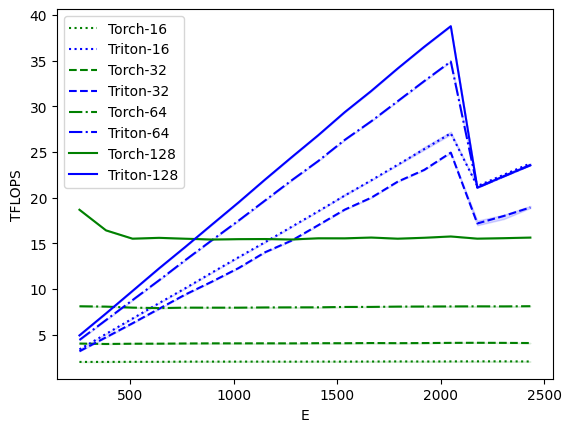

mlp-performance:
         E  Torch-16  Triton-16  Torch-32  Triton-32  Torch-64  Triton-64  Torch-128  Triton-128
0    256.0  2.000463   3.371627  4.012408   3.166309  8.097112   4.405781  18.669009    4.904185
1    384.0  2.001948   5.062782  3.965203   4.692782  8.059081   6.585182  16.412494    7.309980
2    512.0  2.014253   6.750489  3.994338   6.232250  7.948776   8.768580  15.502462    9.771594
3    640.0  2.014168   8.439102  3.999146   7.821059  7.895408  10.938334  15.593658   12.240187
4    768.0  2.034643  10.087850  4.020100   9.394468  7.947103  13.170653  15.496198   14.619959
5    896.0  2.034656  11.794374  4.035075  10.799459  7.943758  15.345182  15.409444   17.056619
6   1024.0  2.034095  13.469815  4.034278  12.282003  7.943601  17.476266  15.450709   19.477250
7   1152.0  2.035631  15.115870  4.038162  14.014969  7.968351  19.688145  15.462344   21.981018
8   1280.0  2.029633  16.804102  4.032985  15.291981  7.976995  21.890939  15.412681   24.423353
9   1408.0  2

In [8]:
benchmark_bwd1.run(show_plots=True, print_data=True)